In [1]:
import pandas as pd

aids = pd.read_csv("aids.csv")
aids_id = pd.read_csv("aids_id.csv")

aids.head()


,patient,Time,death,CD4,obstime,drug,gender,prevOI,AZT,start,stop,event
0,1,16.97,0,10.677078,0,ddC,male,AIDS,intolerance,0,6.00,0
1,1,16.97,0,8.426150,6,ddC,male,AIDS,intolerance,6,12.00,0
2,1,16.97,0,9.433981,12,ddC,male,AIDS,intolerance,12,16.97,0
3,2,19.00,0,6.324555,0,ddI,male,noAIDS,intolerance,0,6.00,0
4,2,19.00,0,8.124038,6,ddI,male,noAIDS,intolerance,6,12.00,0


In [2]:
aids.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1405 entries, 0 to 1404
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   patient  1405 non-null   int64  
 1   Time     1405 non-null   float64
 2   death    1405 non-null   int64  
 3   CD4      1405 non-null   float64
 4   obstime  1405 non-null   int64  
 5   drug     1405 non-null   object 
 6   gender   1405 non-null   object 
 7   prevOI   1405 non-null   object 
 8   AZT      1405 non-null   object 
 9   start    1405 non-null   int64  
 10  stop     1405 non-null   float64
 11  event    1405 non-null   int64  
dtypes: float64(3), int64(5), object(4)
memory usage: 131.8+ KB


In [3]:
# categorical variables
cat_cols = ["drug", "gender", "prevOI", "AZT"]

for c in cat_cols:
    aids[c] = aids[c].astype("category")
    aids_id[c] = aids_id[c].astype("category")

# set reference group: ddC
aids["drug"] = aids["drug"].cat.reorder_categories(["ddC", "ddI"], ordered=True)
aids_id["drug"] = aids_id["drug"].cat.reorder_categories(["ddC", "ddI"], ordered=True)


Baseline CD4

In [4]:
baseline_cd4 = (
    aids.sort_values("obstime")
        .groupby("patient")
        .first()
        .reset_index()[["patient", "CD4"]]
        .rename(columns={"CD4": "baseline_cd4"})
)

aids = aids.merge(baseline_cd4, on="patient", how="left")
aids["time_centered"] = aids["obstime"]


EDA：Baseline CD4 by Drug

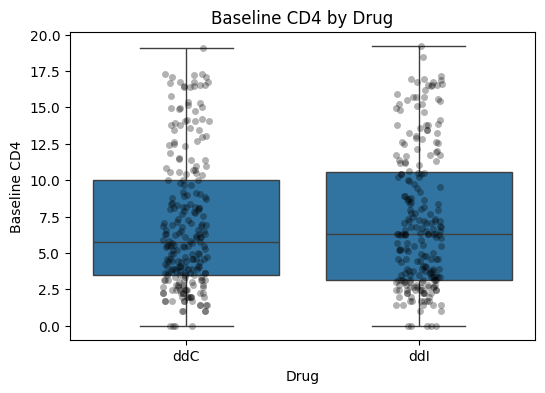

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.boxplot(
    data=aids.drop_duplicates("patient"),
    x="drug", y="baseline_cd4"
)
sns.stripplot(
    data=aids.drop_duplicates("patient"),
    x="drug", y="baseline_cd4",
    color="black", alpha=0.3
)

plt.title("Baseline CD4 by Drug")
plt.xlabel("Drug")
plt.ylabel("Baseline CD4")
plt.show()


cd4 change with time

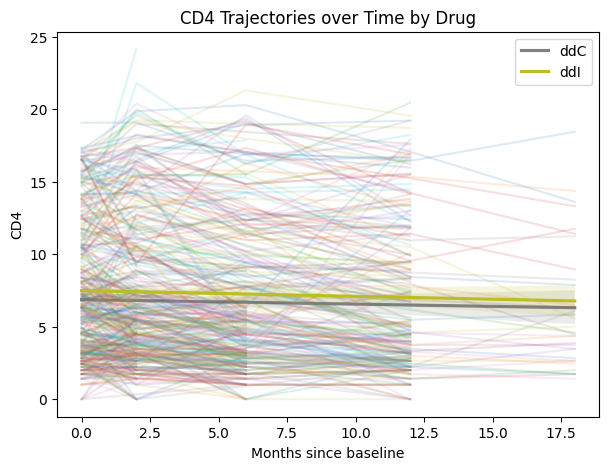

In [6]:
plt.figure(figsize=(7,5))

for d in aids["drug"].cat.categories:
    sub = aids[aids["drug"] == d]
    for pid, g in sub.groupby("patient"):
        plt.plot(g["obstime"], g["CD4"], alpha=0.15)

    sns.regplot(
        data=sub,
        x="obstime", y="CD4",
        scatter=False, label=d
    )

plt.title("CD4 Trajectories over Time by Drug")
plt.xlabel("Months since baseline")
plt.ylabel("CD4")
plt.legend()
plt.show()


GEE

In [7]:
import statsmodels.api as sm
from statsmodels.genmod.generalized_estimating_equations import GEE
from statsmodels.genmod.cov_struct import Independence, Exchangeable, Autoregressive

formula = (
    "CD4 ~ time_centered + drug + time_centered:drug "
    "+ baseline_cd4 + prevOI + AZT"
)

gee_ind = GEE.from_formula(
    formula,
    groups="patient",
    data=aids,
    cov_struct=Independence()
).fit()

gee_ex = GEE.from_formula(
    formula,
    groups="patient",
    data=aids,
    cov_struct=Exchangeable()
).fit()

gee_ar1 = GEE.from_formula(
    formula,
    groups="patient",
    data=aids,
    cov_struct=Autoregressive()
).fit()

print(gee_ind.summary())
print(gee_ex.summary())
print(gee_ar1.summary())


                               GEE Regression Results                              
Dep. Variable:                         CD4   No. Observations:                 1405
Model:                                 GEE   No. clusters:                      467
Method:                        Generalized   Min. cluster size:                   1
                      Estimating Equations   Max. cluster size:                   5
Family:                           Gaussian   Mean cluster size:                 3.0
Dependence structure:         Independence   Num. iterations:                     2
Date:                     Fri, 12 Dec 2025   Scale:                           5.083
Covariance type:                    robust   Time:                         19:17:59
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     0.2390      0.163      1.4

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/genmod/cov_struct.py:796: FutureWarning: grid=True will become default in a future version
  warnings.warn(


GLMM（Random Intercept vs Random Slope）

In [10]:
from statsmodels.regression.mixed_linear_model import MixedLM

md1 = MixedLM.from_formula(
    "CD4 ~ time_centered + drug + time_centered:drug + baseline_cd4 + prevOI + AZT",
    groups="patient",
    data=aids
)
ri_model = md1.fit(reml=False, method="lbfgs")

md2 = MixedLM.from_formula(
    "CD4 ~ time_centered + drug + time_centered:drug + baseline_cd4 + prevOI + AZT",
    groups="patient",
    re_formula="~time_centered",
    data=aids
)
rs_model = md2.fit(reml=False, method="lbfgs")

print("RI AIC:", ri_model.aic)
print("RS AIC:", rs_model.aic)
print("RI BIC:", ri_model.bic)
print("RS BIC:", rs_model.bic)



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:1634: UserWarning: Random effects covariance is singular
  warnings.warn(msg)


RI AIC: 6157.085358694258
RS AIC: 5823.932750174525
RI BIC: 6204.315491930168
RS BIC: 5881.658468573971


In [11]:
print("RI AIC:", ri_model.aic)
print("RS AIC:", rs_model.aic)


RI AIC: 6157.085358694258
RS AIC: 5823.932750174525


Kaplan–Meier

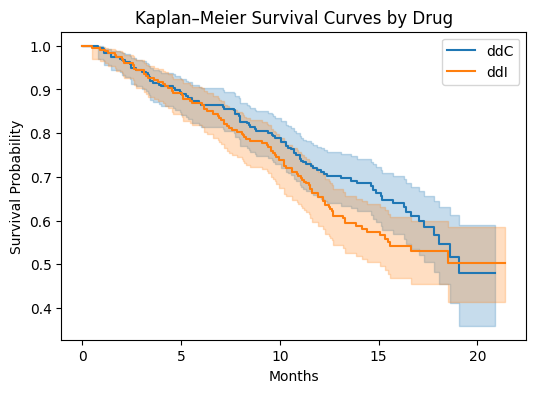

In [12]:
from lifelines import KaplanMeierFitter

kmf = KaplanMeierFitter()

plt.figure(figsize=(6,4))
for d in aids_id["drug"].cat.categories:
    ix = aids_id["drug"] == d
    kmf.fit(
        durations=aids_id.loc[ix, "Time"],
        event_observed=aids_id.loc[ix, "death"],
        label=d
    )
    kmf.plot_survival_function()

plt.title("Kaplan–Meier Survival Curves by Drug")
plt.xlabel("Months")
plt.ylabel("Survival Probability")
plt.show()


Log-rank test

In [13]:
from lifelines.statistics import logrank_test

d0 = aids_id[aids_id["drug"] == "ddC"]
d1 = aids_id[aids_id["drug"] == "ddI"]

logrank_test(
    d0["Time"], d1["Time"],
    d0["death"], d1["death"]
)


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           2.07 0.15      2.73

Cox PH

In [14]:
from lifelines import CoxPHFitter

surv_df = aids_id[["Time", "death", "drug", "CD4", "prevOI", "AZT"]].copy()
surv_df = pd.get_dummies(surv_df, drop_first=True)

cph = CoxPHFitter()
cph.fit(surv_df, duration_col="Time", event_col="death")

cph.print_summary()


<lifelines.CoxPHFitter: fitted with 467 total observations, 279 right-censored observations>
             duration col = 'Time'
                event col = 'death'
      baseline estimation = breslow
   number of observations = 467
number of events observed = 188
   partial log-likelihood = -1029.01
         time fit was run = 2025-12-12 11:23:11 UTC

---
                 coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                        
CD4             -0.15      0.86      0.02           -0.20           -0.10                0.82                0.90
drug_ddI         0.24      1.27      0.15           -0.04            0.53                0.96                1.70
prevOI_noAIDS   -0.79      0.46      0.23           -1.24           -0.33                0.29                0.72
AZT_intolerance -0.12      0.88      0.16           -0.44            0.19                0.64                1.21

                 cmp to     z      p  -log2(p)
covariate                                     
CD4                0.00 -6.36 <0.005     32.17
drug_ddI           0.00  1.65   0.10      3.35
prevOI_noAIDS      0.00 -3.36 <0.005     10.33
AZT_intolerance    0.00 -0.77   0.44      1.18
---
Concordance = 0.72
Partial AIC = 2066.03
log-likelihood ratio test = 111.00 on 4 df
-log2(p) of ll-ratio test = 74.25

conclusion

Longitudinal analysis using generalized estimating equations demonstrated a significant decline in CD4 counts over time, with baseline CD4 level and prior AIDS status emerging as the strongest predictors of immunological progression. Although patients treated with ddI showed higher baseline CD4 levels compared with ddC, no significant interaction between treatment and time was observed, indicating that ddI did not significantly slow the rate of CD4 decline.

Mixed-effects modeling further revealed substantial inter-individual heterogeneity in CD4 trajectories, with the random slope model providing a superior fit compared with the random intercept model. This finding highlights marked variability in disease progression across patients that cannot be fully explained by treatment assignment alone.

Survival analyses yielded consistent results. Kaplan–Meier curves and log-rank testing showed no statistically significant difference in overall survival between treatment groups. In the Cox proportional hazards model, higher CD4 levels and absence of prior AIDS were associated with significantly reduced mortality risk, whereas treatment type did not exhibit a significant effect on survival.

Overall, these findings suggest that immunological status and disease history play a more critical role in both longitudinal CD4 dynamics and survival outcomes than antiretroviral treatment choice between ddC and ddI in this cohort.